In [229]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path

In [230]:
import warnings
warnings.filterwarnings("ignore")

# Données classification de sentiments (films)

## Chargement du petit jeu de données

In [5]:
def load_movies(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    list_dir = os.listdir(path2data)
    if '.DS_Store' in list_dir : list_dir.remove('.DS_Store')
    for cl in list_dir: # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe
        
    return alltxts,labs


In [6]:
from sklearn.model_selection import train_test_split

path = "./datasets/movies/movies1000/"

alltxts,alllabs = load_movies(path)


# Split the small dataset into training and testing sets
sX_train, sX_test, sY_train, sY_test = train_test_split(alltxts, alllabs, test_size=0.2, random_state=42)


In [7]:
print(len(alltxts),len(alllabs))
print("Number of entries in training data : ", len(sX_train))
print("Number of entries in test data : ", len(sX_test))
#print(alltxts[0])
#print(alllabs[0])
#print(alltxts[-1])
#print(alllabs[-1])



2000 2000
Number of entries in training data :  1600
Number of entries in test data :  400


## Chargement du grand jeu de données

In [104]:
import json
from collections import Counter

def split_list_of_tuples(lst):
    x = np.array([i[0] for i in lst])
    y = np.array([i[1] for i in lst])
    return x, y

# Loading json
with open("./datasets/movies/json_pol.json",encoding="utf-8") as f:
    data = f.readlines()
    json_data = json.loads(data[0])
    train = json_data["train"]
    test = json_data["test"]
    

# Quick Check
counter_train = Counter((x[1] for x in train))
counter_test = Counter((x[1] for x in test))
print("Number of train reviews : ", len(train))
print("----> # of positive : ", counter_train[1])
print("----> # of negative : ", counter_train[0])
print("")
print(train[0])
print("")
print("Number of test reviews : ",len(test))
print("----> # of positive : ", counter_test[1])
print("----> # of negative : ", counter_test[0])

print("")
print(test[0])
print("")


## Preparing the big dataset train and test 
X_train,Y_train = split_list_of_tuples(train)
X_test,Y_test = split_list_of_tuples(test)


Number of train reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

["The undoubted highlight of this movie is Peter O'Toole's performance. In turn wildly comical and terribly terribly tragic. Does anybody do it better than O'Toole? I don't think so. What a great face that man has!<br /><br />The story is an odd one and quite disturbing and emotionally intense in parts (especially toward the end) but it is also oddly touching and does succeed on many levels. However, I felt the film basically revolved around Peter O'Toole's luminous performance and I'm sure I wouldn't have enjoyed it even half as much if he hadn't been in it.", 1]

Number of test reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

['Although credit should have been given to Dr. Seuess for stealing the story-line of "Horton Hatches The Egg", this was a fine film. It touched both the emotions and the intellect. Due especially to the incredible performance of seven year old 

# A) Transformation paramétrique du texte (pre-traitements)

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

In [9]:
## Fonctions de base pour le pré-traitement et le nettoyage du texte

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as stopwords

import unicodedata
import string
import re

punc = string.punctuation  # recupération de la ponctuation
punc += '\n\r\t'

def lower(corpus, markers = []):
    """ Met le texte en minuscules sauf les mots correspondant aux marqueurs."""
    return [" ".join(word.upper() if word in markers else word.lower() for word in document.split()) for document in corpus]

def normalize(corpus):
    """ Suppression des accents et des caractères non normalisés """
    return [unicodedata.normalize('NFD', document).encode('ascii', 'ignore').decode("utf-8") for document in corpus]

def del_punc(corpus):
    """ Enlève les ponctuations."""
    return [document.translate(str.maketrans(punc, ' ' * len(punc))) for document in corpus]

def del_num(corpus):
    """ Enlève les chiffres."""
    return [re.sub('[0-9]+', '', document) for document in corpus] # remplacer une séquence de chiffres par rien

def mark_mulpunc(corpus, marker='MULPUNC'):
    """ Transformation des séquences de ponctuation en un marqueur spécifique (marker) """
    ponctuation = '[' + string.punctuation + ']{2,}'
    return [re.sub(ponctuation, ' ' + marker + ' ', txt) for txt in corpus]

def mark_mulmaj(corpus, marker='MULMAJ', n=5):
    """ On ne supprime pas les séquences complètement en majuscule, mais on les fait suivre d'un marqueur (marker)
        @return : str, txt transformé
    """
    marked_corpus = []
    
    for txt in corpus:
        all_maj = re.findall('[A-Z]+[A-Z0-9]{1,}', txt)
        for maj in all_maj:
            txt = re.sub(maj, maj + ' ' + 'MULMAJ ', txt)
            #txt = re.sub(maj,(maj + ' ') * n  + maj, txt)
        marked_corpus.append(txt)
    
    return marked_corpus

def stem(corpus, language):
    """ Racinisation des textes du corpus """
    # Stemmer dans la langue choisie
    stemmer = SnowballStemmer(language, ignore_stopwords=True)
    return [ ' '.join([ stemmer.stem(word) for word in txt.split() ]) for txt in corpus ]

def del_stopwords(corpus, language):
    """ Elimination des stopwords """
    # Liste des stopwords à supprimer (dans la langue choisie)
    stopwords_ = set(stopwords.words(language))
    return [ ' '.join([ word for word in txt.split() if word not in stopwords_ ]) for txt in corpus ]

def select_line(corpus, line=None):
    """ Fonction sélectionnant pour chaque texte du corpus:
            * l'intégralité du texte si line = None
            * la première ligne du texte si line = 0
            * la dernière ligne du texte si line = -1
        A noter que dans les données IMDb, chaque revue a pour dernière ligne ''.
    """
    if line != None:
        return [ txt.split('\n')[:-1][line] for txt in corpus ]
    return corpus

In [10]:
import copy

def text_processor(corpus, language, line=None, mark_punc=False, mark_maj=False, no_punc=False, no_num=False, lowercase=False, norm=False, no_stopwords=False, stemming=False):
    """ Processing paramétrique d'un corpus de texte (cf. chaîne de traitements ci-dessus).
        @param corpus: list(str), corpus de textes
        @param language: {'english', 'french'}
        @param line: {None, 0, -1}, paramètre line de la fonction select_line
        @param mark_mulpunc: {0,1}, vaut 1 si on applique la fonction mark_mulpunc
        @param mark_mulmaj: {0,1}, vaut 1 si on applique la fonction mark_mulmaj
        @param del_punc: {0,1}, vaut 1 si on applique la fonction del_punc
        @param del_num: {0,1}, vaut 1 si on applique la fonction del_num
        @param lower: {0,1}, vaut 1 si on applique la fonction lower
        @param normalize: {0,1}, vaut 1 si on applique la fonction normalize
        @param del_stopwords: {0,1}, vaut 1 si on applique la fonction del_stopwords
        @param stem: {0,1}, vaut 1 si on applique la fonction stem
        @return processed_corpus: list(str), corpus traité
    """
    # Récupération de la ponctuation
    punc = string.punctuation
    punc += '\n\r\t'
    
    # Multiplication multiple
    mulpunc = '[' + string.punctuation + ']{2,}'
    
    # Initialisation du stemmer
    stemmer = SnowballStemmer(language, ignore_stopwords=True)
    
    # Liste des stopwords à supprimer (dans la langue choisie)
    stopwords_ = set(stopwords.words(language))
    
    # Sélection de lignes si spécifié
    processed_corpus = select_line(copy.deepcopy(corpus), line=line)
    
    for i in range(len(processed_corpus)):
        text = processed_corpus[i]
        if mark_punc:
            text = re.sub(mulpunc, ' ' + 'MULPUNC' + ' ', text)
        if mark_maj:
            all_maj = re.findall('[A-Z]+[A-Z0-9]{1,}', text)
            for maj in all_maj:
                text = re.sub(maj, maj + ' ' + 'MULMAJ ', text)
        if no_punc:
            text = text.translate(str.maketrans(punc, ' ' * len(punc)))
        if no_num:
            text = re.sub('[0-9]+', '', text)
        if lowercase:
            markers = ['MULPUNC','MULMAJ']
            text = " ".join( word.upper() if word in markers else word.lower() for word in text.split() )
        if no_stopwords:
            text = ' '.join( word for word in text.split() if word not in stopwords_ )
        if norm:
            text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
        if stemming:
            text = ' '.join( stemmer.stem(word) for word in text.split() )
        processed_corpus[i] = text
    
    return np.array(processed_corpus)

In [11]:
## testes initiaux
doc = 'Le CHAT est devant la maison, 9 rue du zoo... Le chien attend à l\'intérieur.\nSon site web préféré est www.spa.fr '

#print("lower : ",lower([doc]))
#print("\nnormalize : ",normalize([doc]))
#print("\nDelete punctuation : ",del_punc([doc]))
#print("\nDelete numbers : ",del_num([doc]))
#print("\nMark sequence of punctuation : ",mark_mulpunc([doc]))
#print("\nMark sequence of upper case letters : ",mark_mulmaj([doc]))
#print("\nStemming : ",stem([doc],'french'))
#print("\nStopword deletion : ",del_stopwords([doc],'french'))


######################################################
## testes sur le corpus de movies1000
######################################################

#no_punc_texts = del_punc(alltxts)
#print(alltxts[10])
#print(no_punc_texts[10])



In [12]:
import time

start = time.time()
corpus = text_processor(X_test, language='english', line=None, mark_punc=True, mark_maj=True, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)
print('Time elapsed: ', time.time() - start)
print('Number of documents pre-processed : ', len(X_test))

Time elapsed:  73.01340317726135
Number of documents pre-processed :  25000


In [13]:
print(corpus[0])

although credit given dr seuess steal stori line horton hatch egg mulpunc mulmaj mulmaj fine film touch emot intellect due especi incred perform seven year old justin henri script sympathet charact one predica mulpunc mulmaj mulmaj thought provok element linger long tear jerk one overal superior act solid cast excel direct power script right touch humor throughout help keep heavi subject becom tedious difficult sit last film stand test time seem way date decad releas


# B) Extraction du vocabulaire (BoW)

- **Exploration préliminaire des jeux de données**
    - Quelle est la taille d'origine du vocabulaire?
    - Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
    - Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
    - Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
    - Quelle est la distribution d'apparition des mots (Zipf)
    - Quels sont les 100 bigrammes/trigrammes les plus fréquents?

- **Variantes de BoW**
    - TF-IDF
    - Réduire la taille du vocabulaire (min_df, max_df, max_features)
    - BoW binaire
    - Bi-grams, tri-grams
    - **Quelles performances attendrent? Quels sont les avantages et les inconvénients des ces variantes?**

## B.1.1. La taille originale du vocabulaire :

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer()
X_embedded = vectorizer.fit_transform(sX_train)

# Affichage
vocabulaire = vectorizer.get_feature_names_out()
print('Taille vocabulaire = ', len(vocabulaire))
print(X_embedded.toarray())

Taille vocabulaire =  36336
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.03860782 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


## B.1.2. Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]

In [15]:
from collections import Counter

def get_most_common_words(corpus, vocabulary, num_words=100):
    vocabulary = set(vocabulary) ## Convert vocabulary to set so that the membership checking can be done in constant time
    words = []
    for text in corpus:
        words.extend([word for word in text.split() if word in vocabulary])
    word_counts = Counter(words)
    return word_counts.most_common(num_words)

get_most_common_words(sX_train,vocabulaire)

[('the', 61324),
 ('and', 28297),
 ('of', 27274),
 ('to', 25559),
 ('is', 20199),
 ('in', 17292),
 ('that', 12129),
 ('it', 9898),
 ('as', 9024),
 ('with', 8712),
 ('for', 8009),
 ('this', 7625),
 ('his', 7617),
 ('film', 7106),
 ('but', 6910),
 ('he', 6136),
 ('on', 5815),
 ('are', 5529),
 ('by', 4947),
 ('be', 4869),
 ('an', 4634),
 ('one', 4456),
 ('not', 4448),
 ('movie', 4389),
 ('who', 4324),
 ('from', 4001),
 ('was', 3991),
 ('at', 3956),
 ('have', 3922),
 ('has', 3782),
 ('you', 3565),
 ('her', 3541),
 ('all', 3436),
 ('they', 3430),
 ('so', 2941),
 ('about', 2819),
 ('like', 2787),
 ('out', 2758),
 ('more', 2698),
 ('which', 2593),
 ('when', 2587),
 ('up', 2527),
 ('their', 2478),
 ('what', 2475),
 ('or', 2436),
 ('some', 2425),
 ('just', 2337),
 ('if', 2234),
 ('there', 2220),
 ('him', 2137),
 ('into', 2125),
 ('she', 2121),
 ('even', 2073),
 ('only', 1997),
 ('than', 1960),
 ('we', 1959),
 ('no', 1934),
 ('good', 1851),
 ('time', 1841),
 ('most', 1836),
 ('its', 1819),
 ('ca

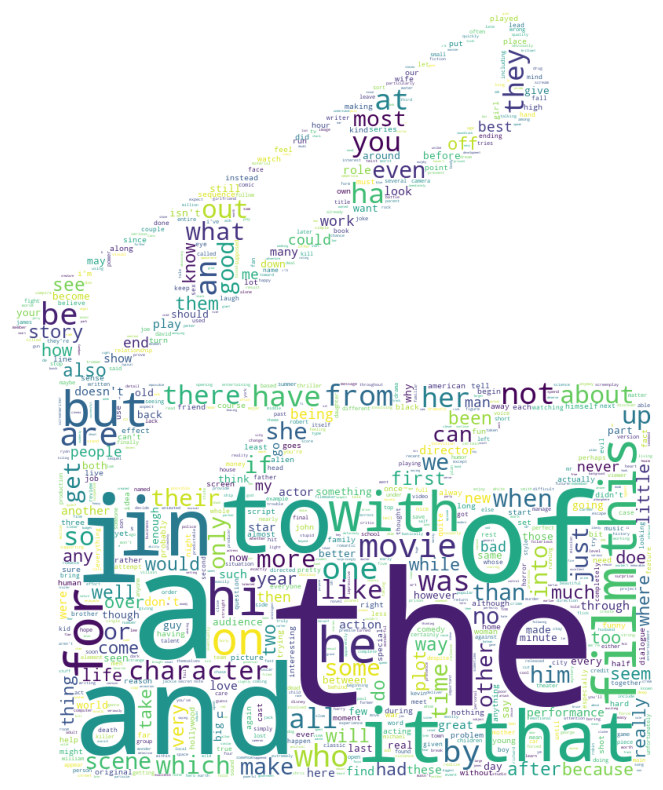

In [16]:
from wordcloud import WordCloud
from PIL import Image
import numpy as np

## Loading the mask image, just for fun and aesthetics
mask = np.array(Image.open("./datasets/movies/mask.png"))

## Regrouping all movie reviews into one big review
text = ' '.join([document for document in sX_train])

# Generating the wordcloud without the use of stopwords
wc = WordCloud(background_color="white", max_words=1000, mask=mask,
               collocations=False, stopwords=[], contour_width=1, contour_color='white')
wc_before = wc.generate(text)

# Visualization
plt.figure(figsize = (15,10))
plt.imshow(wc)
plt.axis("off")
plt.show()


### Remarques:
On peut remarquer que sans l'élimination des stopwords, la descriptivité et la significativé du wordcloud obtenu diminue fortement, à cause de la présence des mots les plus fréquents en anglais *(tel que the, and, to...)*. Ces mots ne décrivent pas notre jeu de données et ne vont servir à rien mis à part l'occupation inutile de l'espace dans le wordcloud. Voyons maintenant le wordcloud qu'on peut obtenir si on élimine les stopwords avant :

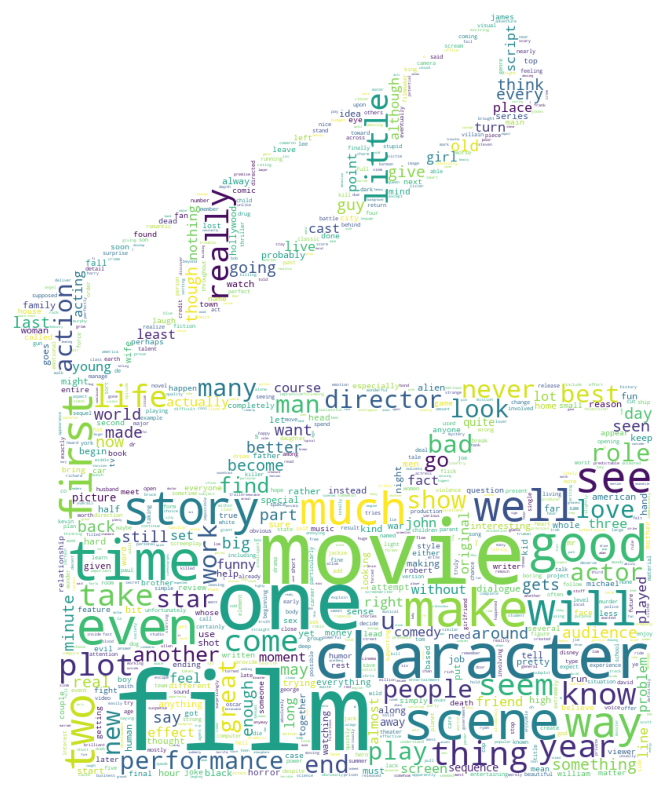

In [17]:
# New wordcloud after eliminating the stopwords first
from wordcloud import STOPWORDS # Note: this is the default option           

wc = WordCloud(background_color="white", max_words=1000, mask=mask,
               collocations=False, stopwords=STOPWORDS, contour_width=1, contour_color='white')
wc_after = wc.generate(text)

# Affichage
plt.figure(figsize = (15,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

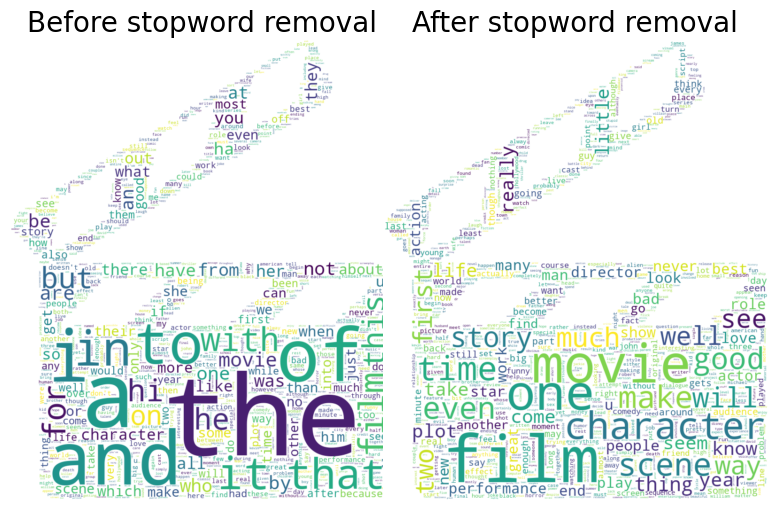

In [18]:
# Showing the word clouds side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
ax1.imshow(wc_before, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("Before stopword removal", fontdict={'fontsize':20, 'y':1.1})
ax1.set_position([0.05, 0.1, 0.4, 0.8])
ax2.imshow(wc_after, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("After stopword removal", fontdict={'fontsize':20, 'y':1.1})
ax2.set_position([0.55, 0.1, 0.4, 0.8])
plt.tight_layout()
plt.show()


## B.1.3. Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]

Dans la classification des sentiments, le l'odds ratio est une mesure de l'association entre une caractéristique (par exemple, un mot) et une classe particulière (par exemple, un sentiment positif ou négatif). La formule de l'odds ratio est la suivante :

$$ \text{odds ratio(mot)} = \frac{p(\text{mot} | \text{positif})  *  (1 - p(\text{mot} | \text{negatif}))}{p(\text{mot} | \text{negatif})  *  (1 - p(\text{mot} | \text{positif}))} $$

où:

**p(mot|positif)** est la probabilité d'observer le mot étant donné que le sentiment est positif.

**p(mot|négatif)** est la probabilité d'observer le mot étant donné que le sentiment est négatif.

L'odds ratio nous indique combien il est plus probable que le mot apparaisse dans la classe positive par rapport à la classe négative. Si l'odds ratio est supérieur à 1, cela suggère que le mot est davantage associé à la classe positive, tandis que si l'odds ratio est inférieur à 1, cela suggère que le mot est  associé à la classe négative.

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np

def compute_odd_ratio(X, Y, eps=0.1,Vectorizer=None):
    """
    Calculates the odds ratio for each word in the corpus.
    If a word's odds ratio is > 1 : it is more likely from a positive reviews, otherwise it's from a negative one.
    
    Arguments:
        X: a list of documents, where each document is a string
        Y: a list of labels for each document in the corpus (Hypothesis that the labels are either 0 or 1)
        eps : Hyperparameter to avoid multiplying by a null probability while calculating odds ratio, changing it gives different results
        ngram_range : hyperparameter of the vectorizer
        Vectorizer : Type of vectorizer, by default it's TF-IDF, we can use CountVectorizer by passing by instanciating it and passing it in the parameter
    Returns:
        A dictionary of words in the corpus's vocabulary, each word is associated with its odds ratio
    """
    X_0 = [X[i] for i in range(len(X)) if Y[i] == 0] ## negative reviews
    X_1 = [X[i] for i in range(len(X)) if Y[i] == 1] ## positive reviews
        
    ## Extract vocabulary of negative reviews and the frequency of each word used
    if Vectorizer is None : vectorizer_0 = TfidfVectorizer()
    else : vectorizer_0 = Vectorizer
    x_0 = vectorizer_0.fit_transform(X_0)
    voc_0 = vectorizer_0.get_feature_names_out()
    word_counts_0 = {}
    for i, word in enumerate(voc_0):
        word_counts_0[word] = x_0[:, i].sum()
    
    ## Extract vocabulary of positive reviews and the frequency of each word used
    if Vectorizer is None : vectorizer_1 = TfidfVectorizer()
    else : vectorizer_1 = Vectorizer
    x_1 = vectorizer_1.fit_transform(X_1)
    voc_1 = vectorizer_1.get_feature_names_out()
    word_counts_1 = {}
    for i, word in enumerate(voc_1):
        word_counts_1[word] = x_1[:, i].sum()
    
    ## Calculate global vocabulary without having to fit a Count Vectorizer to the entire corpus
    voc_global = list(set(voc_0) | set(voc_1))
    
    
    # Calculate the total number of occurrences of each word in each class
    total_word_count_0 = sum(word_counts_0.values())
    total_word_count_1 = sum(word_counts_1.values())
    
    # Calculate term frequency for each class
    prob_word_0 = {word: word_counts_0.get(word,0) / total_word_count_0 for word in voc_global}
    prob_word_1 = {word: word_counts_1.get(word,0) / total_word_count_1 for word in voc_global}

    
    # Calculate the odds ratio for each word
    odds_ratio = {word : (prob_word_1[word] * (1 - prob_word_0[word]) + eps) / ( prob_word_0[word] * (1 - prob_word_1[word]) + eps) for word in voc_global}
    return odds_ratio
    

def visualize_class_wordcloud(odds_ratio, label, n, language='english', mask=None,show=True) :
    """
        Visualize a wordcloud for the given label (0 : negative, 1 : positive) given the odds ratio calculated for 
        each word in the corpus.
    Arguments:
        odds_ratio: A dictionary of words in the corpus's vocabulary, each word is associated with its odds ratio
        label: 0 for negative reviews, 1 for positive reviews.
        n : Maximum number of words in the wordcloud
        language : used to generate the stopwords passed to the wordcloud
        mask : used for the wordcloud mask as a visual aesthetic
        show : the calculated wordcloud is shown if True, otherwise, it won't be. True by default.
    
    Returns:
        The wordcloud corresponding to the label passed as an argument.
    """
    stopwords_list = set(stopwords.words(language))

    if label == 1 : ## we generate the cloud for negative reviews, green color palette chosen
        sorted_ratios = dict(sorted(odds_ratio.items(), key=lambda item: item[1], reverse=True))
        ratios_dict = {word : sorted_ratios[word] for word in list(sorted_ratios.keys())[:n]}
        wc = WordCloud(background_color="white", max_words=n, mask=mask, collocations=False, stopwords=stopwords_list, colormap='viridis',contour_width=0, contour_color='white')
        
    else : ## we generate the cloud for negative reviews, reddish color palette chosen
        sorted_ratios = dict( sorted(odds_ratio.items(), key=lambda item: item[1], reverse=False))
        ratios_dict = {word : 1/sorted_ratios[word] for word in list(sorted_ratios.keys())[:n]}

        wc = WordCloud(background_color="white", max_words=n, mask=mask, collocations=False, stopwords=stopwords_list, colormap='magma',contour_width=0, contour_color='white')

        
    wc = wc.generate_from_frequencies(ratios_dict)

    # Visualization
    if show : 
        plt.figure(figsize = (15,10))
        plt.imshow(wc)
        plt.axis("off")
        plt.show()
        
    return wc

In [53]:
## pre-processing data by activating : removing punctuation, removing numbers, lower-casing, removing stopwords, normalizing, stemming
sX_train_processed = text_processor(sX_train, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)

## Calculating the odds ratio of the dataset
cv = CountVectorizer()
odds_ratio = compute_odd_ratio(sX_train_processed,sY_train,Vectorizer=cv)

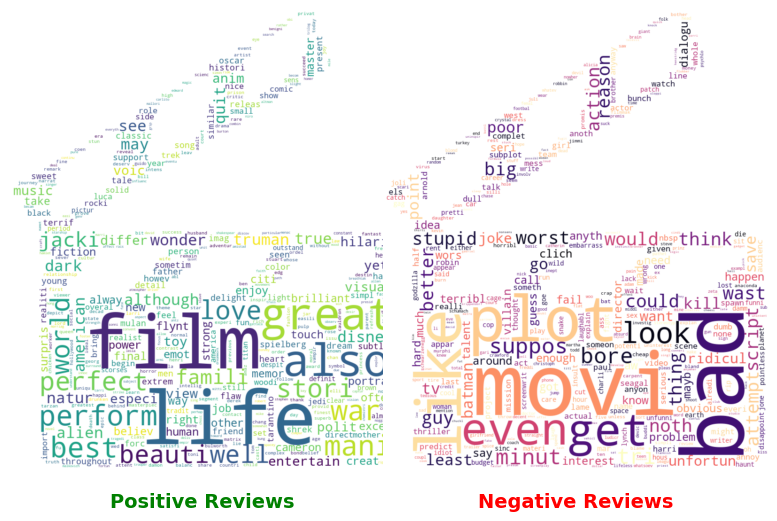

In [54]:
## Positive reviews wordcloud
wordcloud_1 = visualize_class_wordcloud(odds_ratio,1,400,language='english',mask=mask,show=False)

## Negative reviews wordcloud
wordcloud_0 = visualize_class_wordcloud(odds_ratio,0,400,language='english',mask=mask,show=False)


# Showing the word clouds side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
ax1.imshow(wordcloud_1, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("Positive Reviews", fontdict={'fontsize':14, 'y':1.1,'color':'green'}, y = -0.1, weight='bold')
ax1.set_position([0.05, 0.1, 0.4, 0.8])
ax2.imshow(wordcloud_0, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("Negative Reviews", fontdict={'fontsize':14, 'y':1.1,'color':'red'}, y = -0.1, weight='bold')
ax2.set_position([0.55, 0.1, 0.4, 0.8])
plt.tight_layout()
plt.show()


## B.1.3. Quelle est la distribution d'apparition des mots (Zipf) ?

Selon la loi de Zipf, dans une langue naturelle, les mots les plus fréquemment utilisés ont une fréquence d'utilisation beaucoup plus élevée que les mots les moins fréquemment utilisés. De plus, la fréquence relative d'utilisation des mots est inversement proportionnelle à leur rang dans la liste des mots classés par fréquence d'utilisation. Autrement dit, le deuxième mot le plus fréquemment utilisé aura une fréquence d'utilisation environ deux fois plus faible que le mot le plus fréquemment utilisé, le troisième mot aura une fréquence d'utilisation environ trois fois plus faible que le mot le plus fréquemment utilisé, et ainsi de suite.

La loi de Zipf peut être représentée par une courbe log-log, où la fréquence relative d'utilisation des mots est représentée sur l'axe des y, et leur rang sur l'axe des x. La courbe est généralement proche d'une droite, ce qui montre que la relation entre la fréquence d'utilisation et le rang est presque linéaire.

In [403]:
import matplotlib.pyplot as plt
import numpy as np

def plot_zipf_law(word_counts,loglog=True):
    words = [word_count[0] for word_count in word_counts]
    freqs = [word_count[1] for word_count in word_counts]
    
    rank = np.arange(1, len(words)+1)
    plt.loglog(rank, freqs, marker="o") if loglog else plt.plot(rank,freqs,marker="o")
    plt.title("Zipf's Law Plot (log-log)") if loglog else plt.title("Zipf's Law Plot")
    plt.xlabel("Rank")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

mcw_with_stopwords = get_most_common_words(sX_train,vocabulaire) ## blue color
mcw_without_stopwords = get_most_common_words(sX_train_processed,vocabulaire) ## orange color

<IPython.core.display.Javascript object>


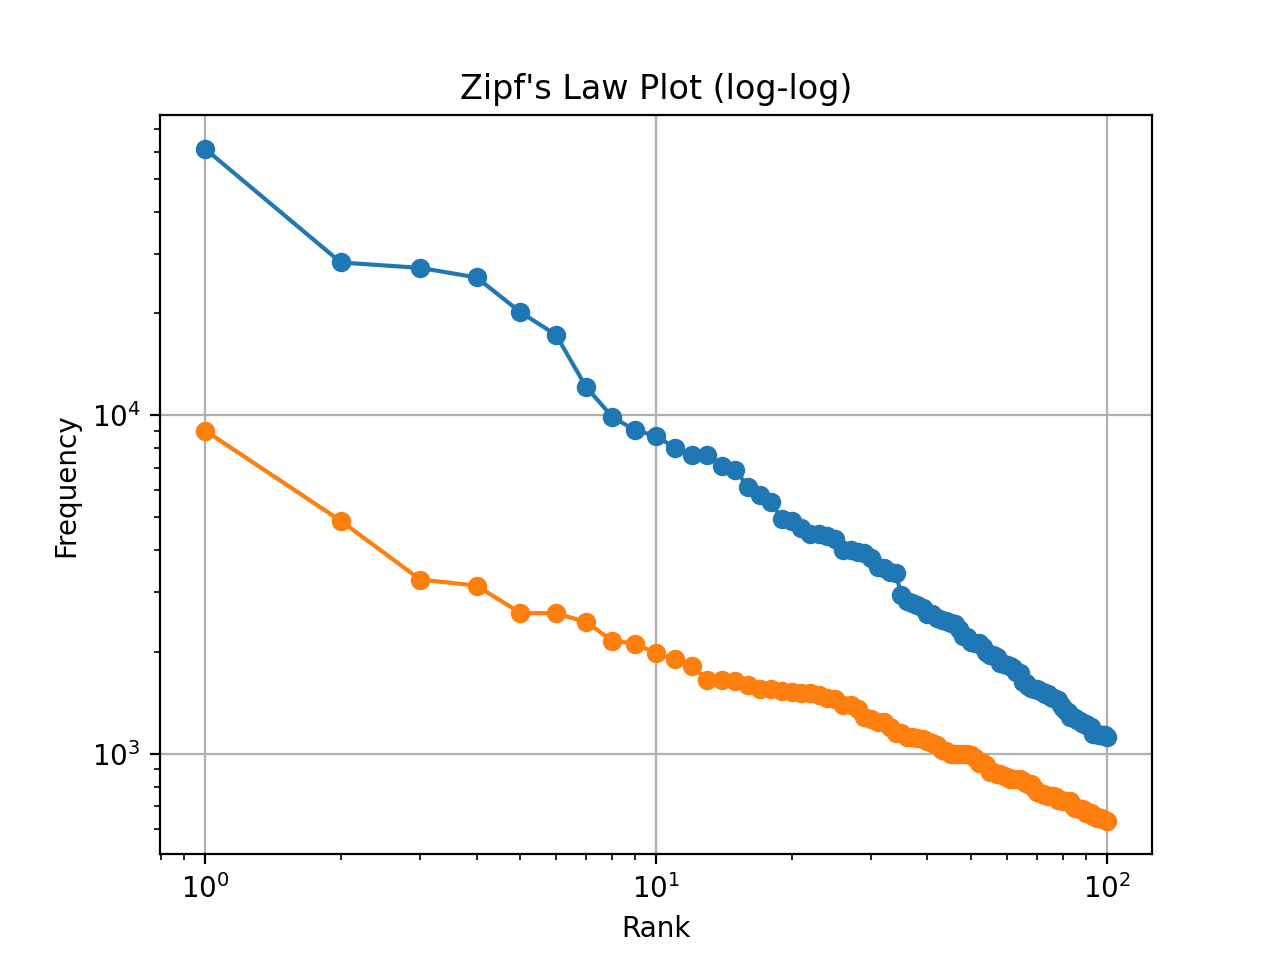

In [404]:
# Plotting log-log distribution of words before and after removal of stopwords
plot_zipf_law(mcw_with_stopwords)
plot_zipf_law(mcw_without_stopwords)

<IPython.core.display.Javascript object>


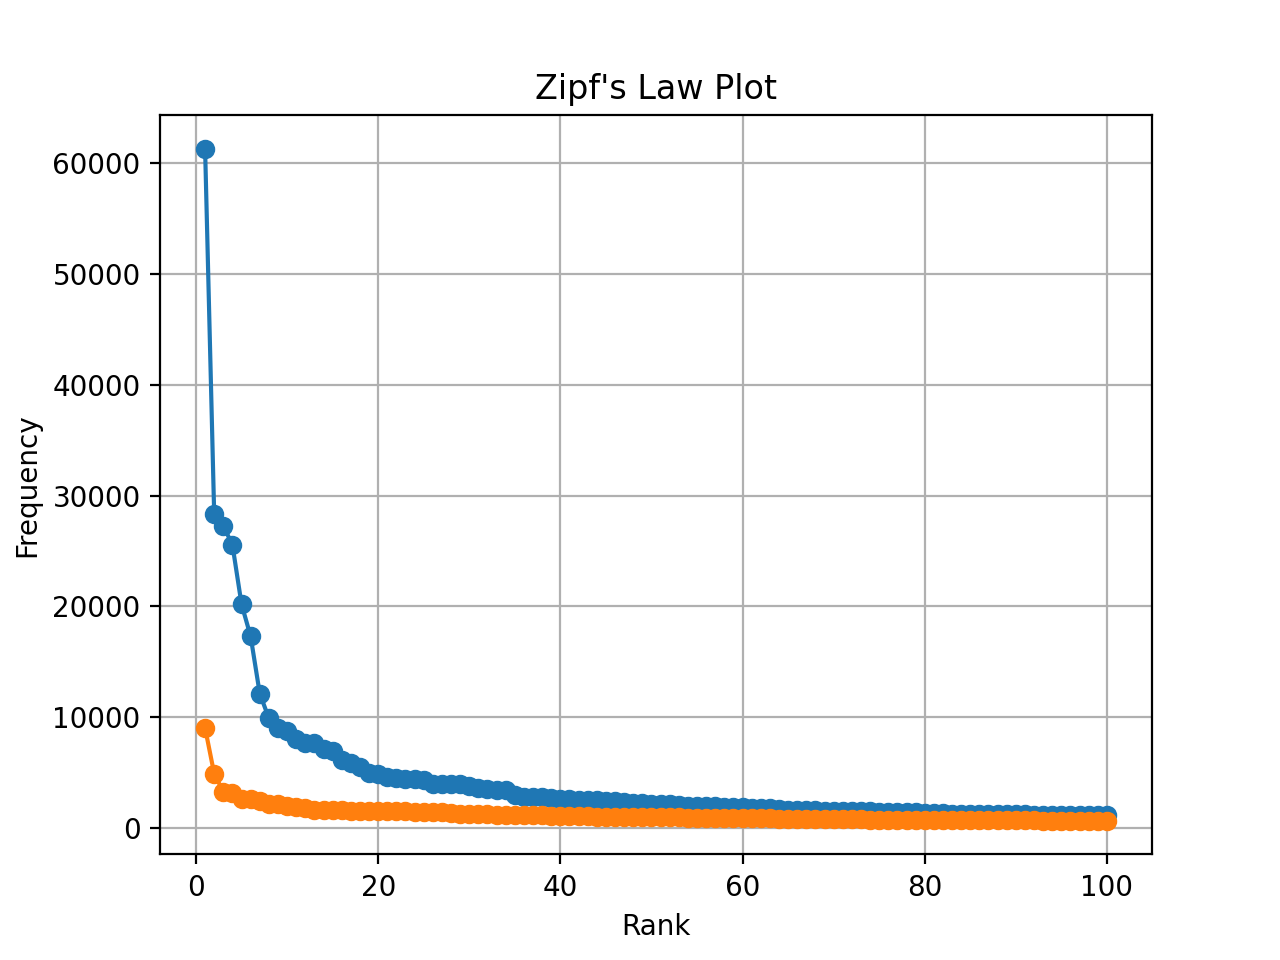

In [405]:
## Plotting normal distribution of words before and after removal of stopwords
plot_zipf_law(mcw_with_stopwords,False)
plot_zipf_law(mcw_without_stopwords,False)

## B.1.4. Quels sont les 100 bigrammes/trigrammes les plus fréquents?

In [406]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def get_top_ngrams(texts,ngram_range,topk=100):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    ngram_counts = dict(zip(feature_names, X.toarray().sum(axis=0)))
    top_k_ngrams = sorted(ngram_counts.items(), key=lambda x: x[1], reverse=True)[:topk]
    return top_k_ngrams

In [407]:
## Calculating the top 100 bigrams
top_100_bigrams = get_top_ngrams(sX_train_processed,(2,2))

## Calculating the top 100 trigrams
top_100_trigrams = get_top_ngrams(sX_train_processed,(3,3))

In [408]:
print("TOP 30 BIGRAMMES : ")
top_100_bigrams[:30]

TOP 30 BIGRAMMES : 


[('special effect', 324),
 ('look like', 248),
 ('new york', 188),
 ('year old', 186),
 ('even though', 175),
 ('bad guy', 166),
 ('seem like', 165),
 ('film like', 151),
 ('star war', 150),
 ('take place', 143),
 ('high school', 133),
 ('sci fi', 120),
 ('scienc fiction', 115),
 ('horror film', 114),
 ('fall love', 113),
 ('movi like', 113),
 ('one best', 112),
 ('action film', 111),
 ('make film', 106),
 ('one thing', 106),
 ('main charact', 105),
 ('action sequenc', 102),
 ('last year', 102),
 ('box offic', 99),
 ('first film', 99),
 ('bad movi', 97),
 ('run time', 97),
 ('star trek', 97),
 ('writer director', 96),
 ('best friend', 95)]

On peut déja commencer a remarquer que l'inclusion des bi-grammes dans le vocabulaire du corpus ajoute de la sémantique et du sens. Dans le cas oû on utilise que des mots unaire, on se retrouve avec pas mal de mots qui décrivent les sentiments de la personne qui rédige, mais il existe un nombre important de mots qui ne décrivent pas les sentiments s'ils sont présentés en forme de 1-gramme ou Bi-gramme, par exemple :

- **Movie VS Bad Movie :** le mot "Movie" ne permet pas de dire si la personne qui a redigé le review aime le film ou non, contrairement à Bad Movie.
- **One VS One Best :** le mot "One" ne permet pas de dire si la personne qui a redigé le review aime le film ou non, contrairement à "One Best" qui correspond à "One of the Best" après la suppression des stopwords "the" et "of".

In [409]:
print("TOP 15 TRIGRAMMES : ")
top_100_trigrams[:15]

TOP 15 TRIGRAMMES : 


[('know last summer', 45),
 ('new york citi', 42),
 ('save privat ryan', 38),
 ('blair witch project', 34),
 ('tommi lee jone', 31),
 ('robert de niro', 28),
 ('scienc fiction film', 28),
 ('film take place', 26),
 ('wild wild west', 26),
 ('jay silent bob', 25),
 ('saturday night live', 24),
 ('world war ii', 23),
 ('thin red line', 22),
 ('freddi prinz jr', 21),
 ('sci fi film', 21)]

Avec les tri-grammes, on obtient encore plus de sémantique sur les reviews, tel que les noms des films et les noms des acteurs associés à ces films (bien sûr, il faut que les noms de ces films et de ces acteurs soient composés de trois mots, sinon, s'il sont composé que de deux mots, ils auront plus de chance à être présents dans la liste des bi-grammes si mentionés suffisement... etc)

**Essayons de recalculer le dictionnaire de odds_ratio en prenant comme vocabulaire les bigrammes et les trigrammes cette fois-ci**

**REMARQUE : le temps de calcul peut être très très long, à cause de l'explosion de la taille du vocabulaire**

In [45]:
## pre-processing data by activating : removing punctuation, removing numbers, lower-casing, removing stopwords, normalizing, stemming
sX_train_processed = text_processor(sX_train, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)

## Calculating the odds ratio of the dataset, by including only bigrams in the vocabulary
cv = CountVectorizer(ngram_range=(2,2))
start = time.time()
odds_ratio_bigrams = compute_odd_ratio(sX_train_processed,sY_train,Vectorizer=cv)
print('Time elapsed: ', time.time() - start)

KeyboardInterrupt: 

In [436]:
print("Taille du dictionnaire composé des mots d'unité seulement : ", len(odds_ratio))
print("Taille du dictionnaire composé des bi-grammes seulement : ", len(odds_ratio_bigrams))

print("La taille du vocabulaire est " + f"{round(len(odds_ratio_bigrams)/len(odds_ratio))}" + " fois plus grande.")

Taille du dictionnaire composé des mots d'unité seulement :  22835
Taille du dictionnaire composé des bi-grammes seulement :  398547
La taille du vocabulaire est 17 fois plus grande.


<IPython.core.display.Javascript object>


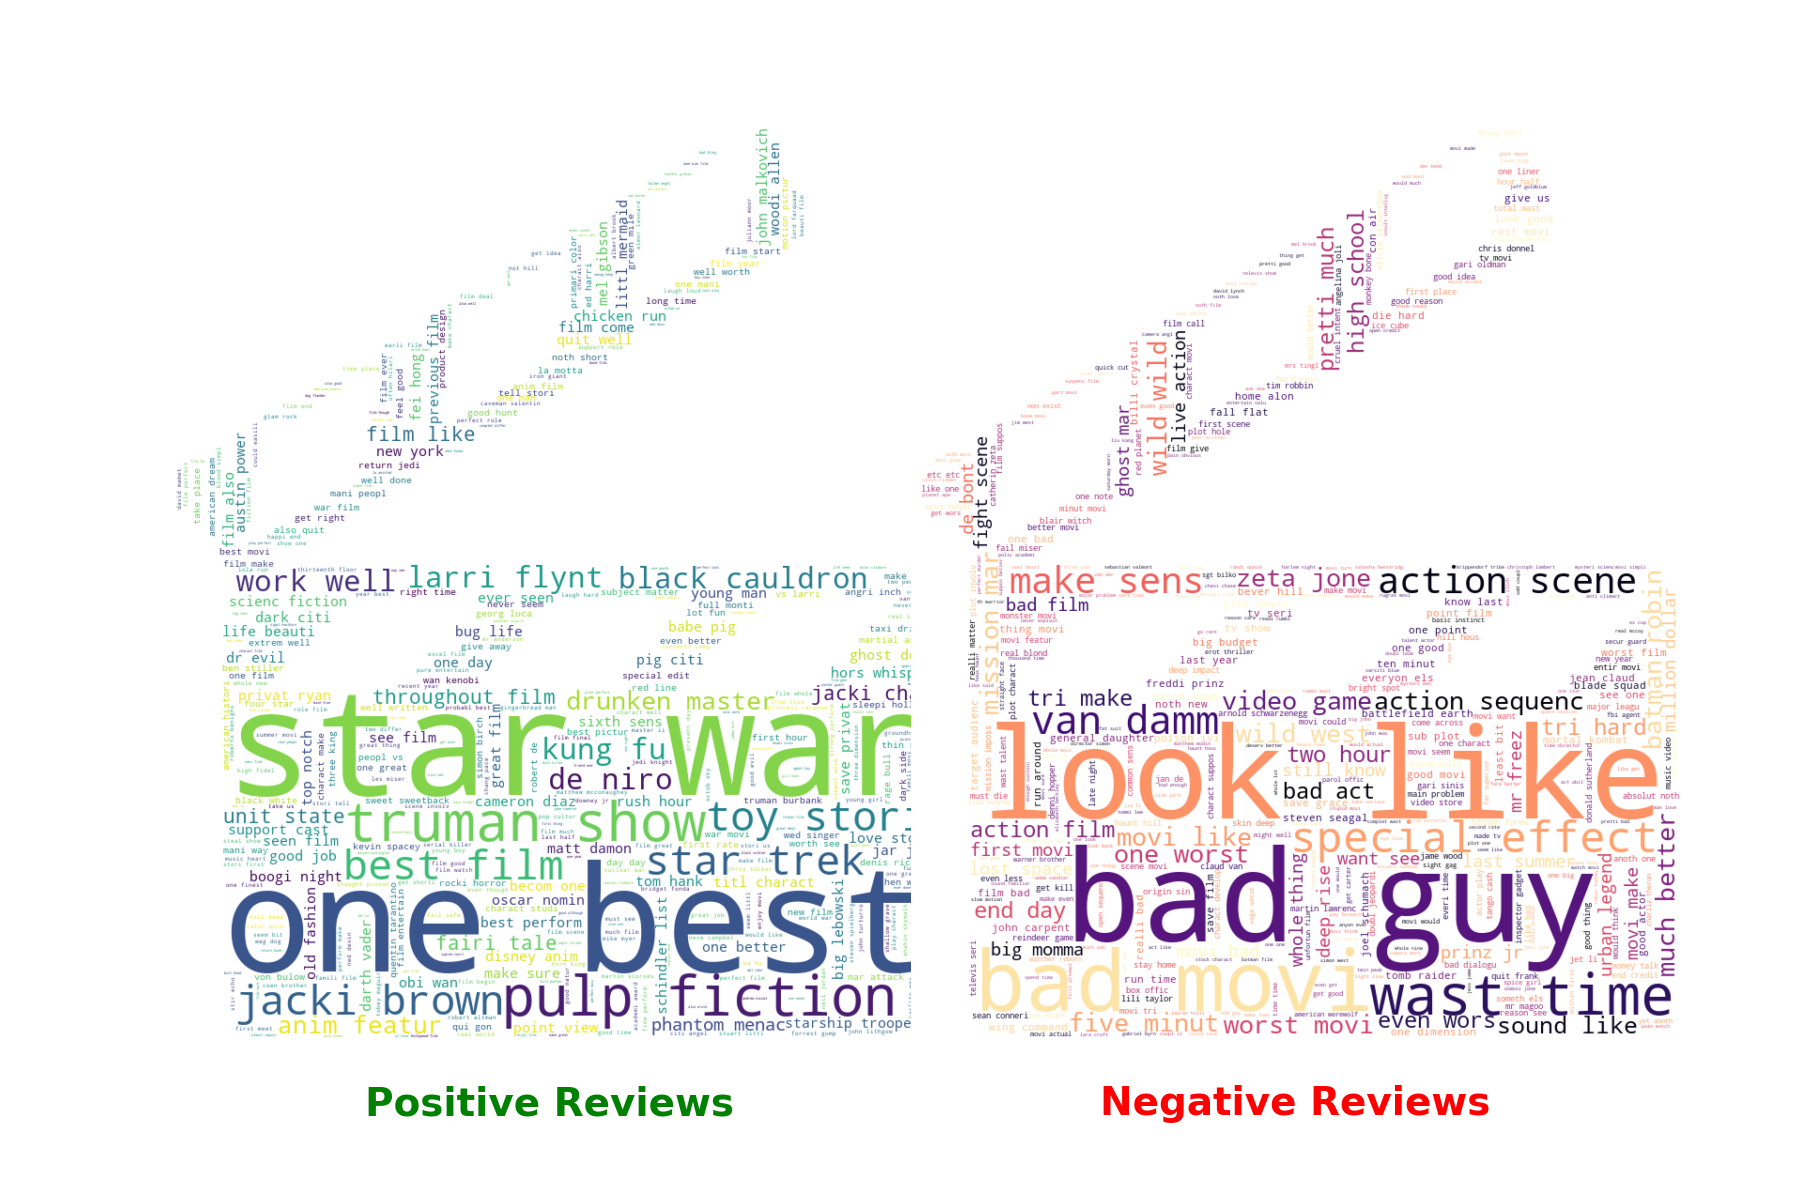

In [428]:
## Positive reviews wordcloud
wordcloud_1 = visualize_class_wordcloud(odds_ratio_bigrams,1,400,language='english',mask=mask,show=False)

## Negative reviews wordcloud
wordcloud_0 = visualize_class_wordcloud(odds_ratio_bigrams,0,400,language='english',mask=mask,show=False)


# Showing the word clouds side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
ax1.imshow(wordcloud_1, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("Positive Reviews", fontdict={'fontsize':14, 'y':1.1,'color':'green'}, y = -0.1, weight='bold')
ax1.set_position([0.05, 0.1, 0.4, 0.8])
ax2.imshow(wordcloud_0, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("Negative Reviews", fontdict={'fontsize':14, 'y':1.1,'color':'red'}, y = -0.1, weight='bold')
ax2.set_position([0.55, 0.1, 0.4, 0.8])
plt.tight_layout()
plt.show()


**Remarques :**

En utilisant que les bi-grammes pour representer le vocabulaire, on obtient déja plus d'information que la representation précedente. Cette fois si, des noms très connus sautent aux yeux dans les wordclouds générés.

Un exemple assez évident est la presence de : **star wars**, **pulp fiction**, **de niro** dans le wordcloud des reviews positifs. Alors que le vocabulaire composé des mots unaires permet de classifier le sentiment à travers des mots distinctifs tel que **good** ou **bad**, l'effet que les bi-grammes peuvent apporter est l'association de certains films et certains acteurs à la classe des reviews positifs, indiquant que ces derniers sont appreciés par la population, ou bien dans la classe des reviews négatifs.

On constate alors que l'utilisation des bi-grammes peut être enrichissante si on veut tirer d'autres informations mis à part les sentiments, tel que les bons films et les grands acteurs. Il faut bien sûr ne pas pénaliser les acteurs et les films qui se trouvent dans le wordcloud des reviews négatifs (Blair Witch est un film excellent et Gary Oldman est un bon acteur, mais ils n'étaient pas chanceux dans ce jeu de données car ils étaient mentionés dans plus de reviews négatifs que des reviews positifs).

In [430]:
## pre-processing data by activating : removing punctuation, removing numbers, lower-casing, removing stopwords, normalizing, stemming
sX_train_processed = text_processor(sX_train, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)

## Calculating the odds ratio of the dataset, by including bigrams and trigrams in the vocabulary (no unitary words)

cv = CountVectorizer(ngram_range=(2,3))
start = time.time()
odds_ratio_enhanced = compute_odd_ratio(sX_train_processed,sY_train,Vectorizer=cv)
print('Time elapsed: ', time.time() - start)

Time elapsed:  323.9428520202637


In [434]:
print("Taille du dictionnaire composé des mots d'unité seulement : ", len(odds_ratio))
print("Taille du dictionnaire composé des bi-grammes et tri-grammes : ", len(odds_ratio_enhanced))

print("La taille du vocabulaire est " + f"{round(len(odds_ratio_enhanced)/len(odds_ratio))}" + " fois plus grande.")

Taille du dictionnaire composé des mots d'unité seulement :  22835
Taille du dictionnaire composé des bi-grammes et tri-grammes :  940325
La taille du vocabulaire est 41 fois plus grande.


<IPython.core.display.Javascript object>


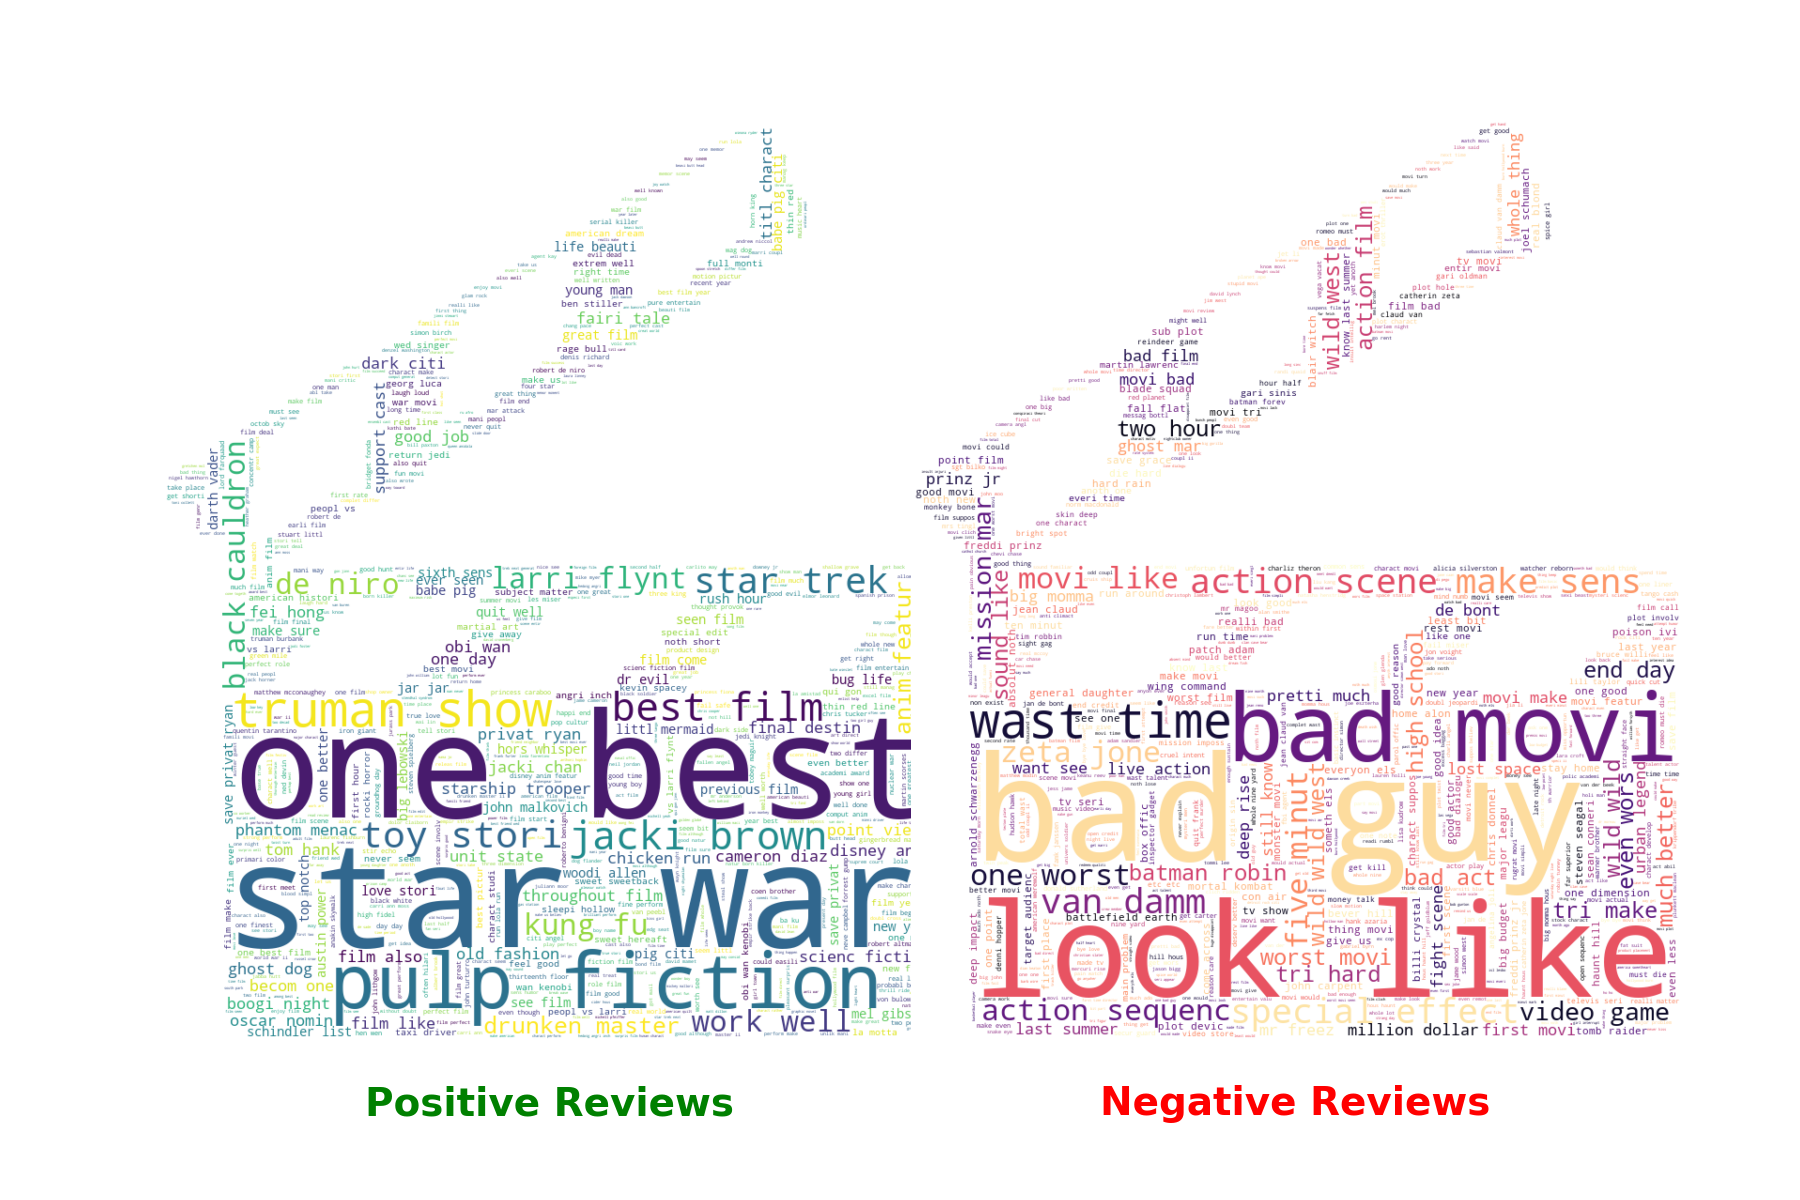

In [432]:
## Positive reviews wordcloud
wordcloud_1 = visualize_class_wordcloud(odds_ratio_enhanced,1,600,language='english',mask=mask,show=False)

## Negative reviews wordcloud
wordcloud_0 = visualize_class_wordcloud(odds_ratio_enhanced,0,600,language='english',mask=mask,show=False)


# Showing the word clouds side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
ax1.imshow(wordcloud_1, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("Positive Reviews", fontdict={'fontsize':14, 'y':1.1,'color':'green'}, y = -0.1, weight='bold')
ax1.set_position([0.05, 0.1, 0.4, 0.8])
ax2.imshow(wordcloud_0, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("Negative Reviews", fontdict={'fontsize':14, 'y':1.1,'color':'red'}, y = -0.1, weight='bold')
ax2.set_position([0.55, 0.1, 0.4, 0.8])
plt.tight_layout()
plt.show()


**Remarque :**
La première chose qu'on remarque après l'inclusion des tri-grammes en plus des bi-grammes, est l'explosion de la taille du vocabulaire. Le vocabulaire qui contient que les bi-grammes est **17 fois** plus grand que le vocabulaire qui contient que les mots unaires, alors que le vocabulaire qui contient les bi-grammes et les tri-grammes est **41 fois** plus grand que le vocabulaire qui contient que les mots unaires.

En plus de ça, les wordclouds obtenu à la suite ne sont pas si différents des wordclouds obtenu par la présence seule des bi-grammes. 

À l'aide des wordclouds obtenus au début en utilisant que des mots unitaires, on peut commencer à classifier les sentiments, et avec les wordclouds obtenus avec les bi-grammes, on peut commencer à associer des concepts (films ou acteurs) aux sentiments positifs et négatifs.

La prise en considération des tri-grammes n'apporte pas grand-chose ici, et le temps de calcul est très pénible.

## B.2.1. TF-IDF EMBEDDING :

Le TF-IDF (Term Frequency - Inverse Document Frequency) est une technique de traitement du langage naturel qui permet de transformer du texte en un vecteur de nombres. Le processus consiste à calculer un score TF-IDF pour chaque mot dans chaque document d'un corpus, où le score TF-IDF est défini comme le produit de la fréquence du terme (TF) et de l'inverse de la fréquence dans le corpus (IDF). La formule pour le score TF-IDF est donnée par :

$$\text{tf-idf}(t,d)=\text{tf}(t,d)×\text{idf}(t)$$

où $t$ est un terme (mot), $d$ est un document, $\text{tf}(t,d)$ est la fréquence du terme $t$ dans le document $d$ et $\text{idf}(t)$ est l'inverse de la fréquence du terme $t$ dans le corpus.

L'embedding TF-IDF consiste à utiliser la technique TF-IDF pour générer des embeddings de mots (représentations vectorielles de mots) à partir d'un corpus de documents. Ces embeddings peuvent ensuite être utilisés comme entrée pour un modèle de classification de texte.

Pour utiliser l'embedding TF-IDF avec la base de données IMDB (Internet Movie Database) qui contient des critiques de films, nous devons d'abord prétraiter les données en les nettoyant. Ensuite, nous pouvons utiliser la classe TfidfVectorizer du module scikit-learn pour générer les embeddings, et on va comparer les résultats obtenus avec un Count-Vectorizer.

**Il est important de noter que les termes qui apparaissent souvent dans un document donné, mais pas dans d'autres documents de l'ensemble de données, peuvent donc avoir un poids plus important pour la classification de sentiments.**



In [46]:
## pre-processing data by activating : removing punctuation, removing numbers, lower-casing, removing stopwords, normalizing, stemming
sX_train_processed = text_processor(sX_train, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)

## Calculating the odds ratio of the datasets for both tfidf embedding and count embeddings (for comparison)
tfidf = TfidfVectorizer()
cv = CountVectorizer()

odds_ratio_tfidf = compute_odd_ratio(sX_train_processed,sY_train,Vectorizer=tfidf)
odds_ratio_count = compute_odd_ratio(sX_train_processed,sY_train,Vectorizer=cv)


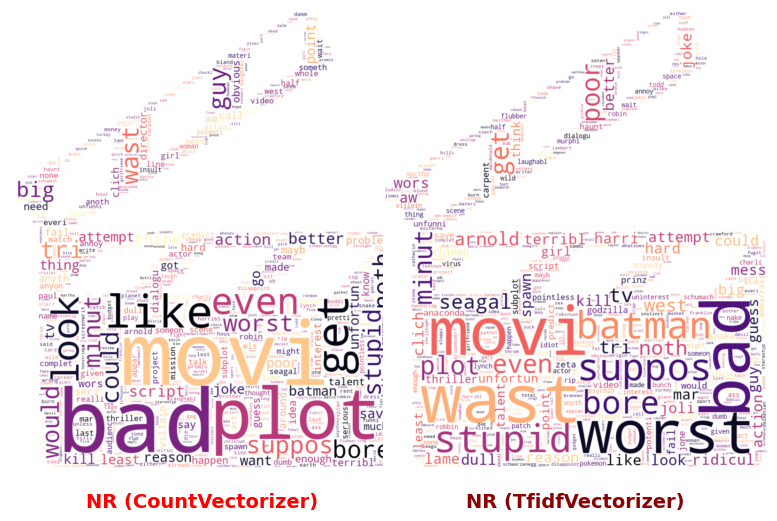

In [47]:
## Negative reviews wordcloud with count vectorizer
wordcloud_0_count = visualize_class_wordcloud(odds_ratio_count,0,600,language='english',mask=mask,show=False)

## Negative reviews wordcloud with tf-idf vectorizer
wordcloud_0_tfidf = visualize_class_wordcloud(odds_ratio_tfidf,0,600,language='english',mask=mask,show=False)

# Showing the word clouds side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
ax1.imshow(wordcloud_0_count, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("NR (CountVectorizer)", fontdict={'fontsize':14, 'y':1.1,'color':'red'}, y = -0.1, weight='bold')
ax1.set_position([0.05, 0.1, 0.4, 0.8])
ax2.imshow(wordcloud_0_tfidf, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("NR (TfidfVectorizer)", fontdict={'fontsize':14, 'y':1.1,'color':'#8B0000'}, y = -0.1, weight='bold')
ax2.set_position([0.55, 0.1, 0.4, 0.8])
plt.tight_layout()
plt.show()


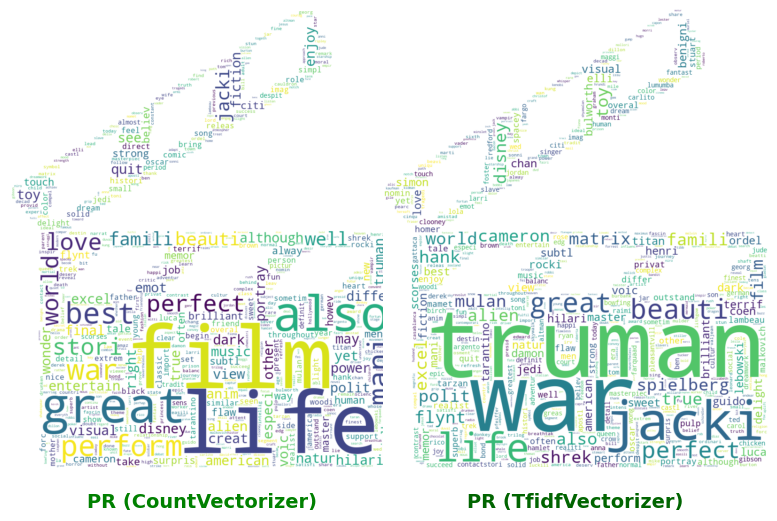

In [48]:
## Positive reviews wordcloud with count vectorizer
wordcloud_1_count = visualize_class_wordcloud(odds_ratio_count,1,600,language='english',mask=mask,show=False)

## Positive reviews wordcloud with tf-idf vectorizer
wordcloud_1_tfidf = visualize_class_wordcloud(odds_ratio_tfidf,1,600,language='english',mask=mask,show=False)

# Showing the word clouds side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
ax1.imshow(wordcloud_1_count, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("PR (CountVectorizer)", fontdict={'fontsize':14, 'y':1.1,'color':'green'}, y = -0.1, weight='bold')
ax1.set_position([0.05, 0.1, 0.4, 0.8])
ax2.imshow(wordcloud_1_tfidf, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("PR (TfidfVectorizer)", fontdict={'fontsize':14, 'y':1.1,'color':'#006400'}, y = -0.1, weight='bold')
ax2.set_position([0.55, 0.1, 0.4, 0.8])
plt.tight_layout()
plt.show()


**Commentaires :**

* **Negative reviews :** TF-IDF donne des résultats qui mettent en évidence plus de mots négatifs que le Count-Vectorizer, tel que "stupid", ou "waste". 
* **Positive reviews :** Les résultats entre les deux sont plus ou moins les mêmes.

**Mais pourquoi?**

Le TF-IDF est meilleur que le Count-Vectorizer lorsqu'il s'agit d'un problème de classification de sentiments pour plusieurs raisons : 

1. **Pondération des termes :** Le TF-IDF attribue des poids différents aux termes en fonction de leur fréquence dans le document et leur fréquence inverse dans l'ensemble du corpus. Ainsi, les termes qui apparaissent fréquemment dans un document mais rarement dans l'ensemble du corpus seront pondérés plus lourdement. Cela aide à atténuer l'impact des mots courants qui ne sont pas spécifiques à un document particulier, **dans la suite de cette explication, nous allons considerer ces mots comme des stopwords, même s'ils ne sont pas des stopwords au sens classique, ils le sont dans cette base de données (par exemple : le mot "movie" qui apparait énormement dans cette DB).**


2. **Réduction de la dimensionnalité :** Les techniques basées sur le Count Vectorizer ont tendance à produire des matrices de grande dimension, ce qui peut poser des problèmes de surapprentissage. En revanche, le TF-IDF réduit la dimensionnalité en éliminant les termes qui ont une faible fréquence et en pondérant les termes restants en fonction de leur importance.


3. **Gestion des stopwords (stopwords pas au sens classique) :** Le Count Vectorizer ne tient pas compte des stopwords, qui peuvent être des indicateurs importants pour la classification des sentiments. En revanche, le TF-IDF peut donner une importance accrue aux stopwords qui apparaissent fréquemment dans les documents mais rarement dans l'ensemble du corpus, ce qui peut améliorer les performances de la classification des sentiments.



### Que-ce-passe t'il si on ne retire pas les stop-words pour TF-IDF?

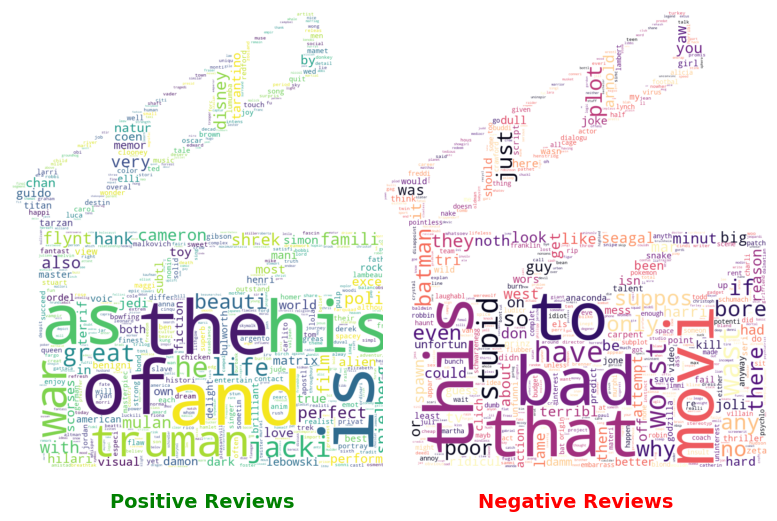

In [49]:
## Reprocessing text, but without removing stop words this time
sX_train_processed = text_processor(sX_train, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=False, norm=True, stemming=True)

## Calculating the odds ratio of the datasets for both tfidf embedding and count embeddings (for comparison)
odds_ratio_tfidf = compute_odd_ratio(sX_train_processed,sY_train)

## Positive reviews wordcloud
wordcloud_1 = visualize_class_wordcloud(odds_ratio_tfidf,1,600,language='english',mask=mask,show=False)

## Negative reviews wordcloud
wordcloud_0 = visualize_class_wordcloud(odds_ratio_tfidf,0,600,language='english',mask=mask,show=False)

# Showing the word clouds side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
ax1.imshow(wordcloud_1, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("Positive Reviews", fontdict={'fontsize':14, 'y':1.1,'color':'green'}, y = -0.1, weight='bold')
ax1.set_position([0.05, 0.1, 0.4, 0.8])
ax2.imshow(wordcloud_0, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("Negative Reviews", fontdict={'fontsize':14, 'y':1.1,'color':'red'}, y = -0.1, weight='bold')
ax2.set_position([0.55, 0.1, 0.4, 0.8])
plt.tight_layout()
plt.show()


**Remarque :** 
Bizarrement, le wordcloud des reviews négatifs reste toujours capable de mettre en évidence quelques mots qui décrivent des mauvais sentiments, alors que le wordcloud des reviews positifs est complètement bombardé avec les stopwords classiques de la langue anglaise.

**Explication :**

Dans certains cas, TF-IDF peut être plus efficace pour la classification des sentiments négatifs que pour les sentiments positifs. Cela peut s'expliquer par le fait que les mots négatifs sont souvent **plus rares et plus spécifiques.** En autre mots : 

Les mots associés à des sentiments négatifs tels que "hate", "horrible" et "terrible" sont souvent moins fréquents que les mots associés à des sentiments positifs tels que "good", "nice" et "like". Cela signifie que les mots négatifs peuvent avoir un poids plus important dans la méthode TF-IDF, car ils sont plus spécifiques à un sentiment négatif donné. Les mots positifs, par contre, seront auront un poids moins important car ils apparaissent très fréquemment dans les documents (même les documents négatifs, par exemple "i don't **like** it", "not **good**".

**On a plus la tendance de dire : "not good" pour exprimer un sentiment négatif, pour être moins méchant, que de dire "not bad" pour exprimer un sentiment positif, au lieu d'utiliser un terme plus gentil tel que "good", ou "great". En gros, on a la tendance d'exprimer nos sentiments en essayant d'être le plus gentil possible, ha!**

Dans certains domaines, il peut être plus important de détecter les sentiments négatifs que les sentiments positifs. Par exemple, dans le domaine de la surveillance de la réputation en ligne, il est plus intéressant de détecter les critiques négatives que les commentaires positifs. Dans ces cas, une erreur de classification pour un sentiment positif peut être moins préjudiciable qu'une erreur de classification pour un sentiment négatif.


## B.2.2. Réduction de la taille du vocabulaire :

La réduction du vocabulaire peut améliorer les résultats, plus spécifiquement : 


* Ça peut aider à éviter le surapprentissage (overfitting) du modèle. Le surapprentissage se produit lorsque le modèle apprend à mémoriser les données d'entraînement plutôt que de généraliser à de nouvelles données. Si le vocabulaire est trop grand, il est possible que le modèle apprenne à mémoriser les mots spécifiques à l'ensemble d'entraînement, plutôt que d'apprendre à reconnaître les motifs généraux qui permettent de classifier les sentiments. En réduisant le vocabulaire, on peut réduire le risque de surapprentissage et améliorer la capacité du modèle à généraliser à de nouvelles données.

* Ça peut permettre d'améliorer la vitesse de traitement des données, ce qui peut être particulièrement important dans le cas de grandes bases de données. En effet, plus le vocabulaire est grand, plus le temps de calcul nécessaire pour traiter les données sera important. En réduisant le vocabulaire, on peut accélérer le traitement des données et rendre le modèle plus efficace.

In [63]:
# max_df: float (ratio) / integer(number) of document above which we remove the word)
# min_df: float (ratio) / integer(number) of document under which we remove the word)

min_df = 1             
max_df = 0.3
max_features=10000

## Initializing vectorizers
cv = CountVectorizer(min_df=min_df,max_df=max_df,max_features=max_features)
tfidf = TfidfVectorizer(min_df=min_df,max_df=max_df,max_features=max_features)

## pre-processing data by activating : no need to remove stopwords, max_df will take care of it
sX_train_processed = text_processor(sX_train, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)

## Calculating the odds ratio of the datasets for both tfidf embedding and count embeddings (for comparison)
odds_ratio_tfidf = compute_odd_ratio(sX_train_processed,sY_train,Vectorizer=tfidf)
odds_ratio_count = compute_odd_ratio(sX_train_processed,sY_train,Vectorizer=cv)

# C) Modèles de Machine Learning

In [65]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate
import os
import time

## 1) Métriques d'évaluation 

Il faudra utiliser des métriques d'évaluation pertinentes suivant la tâche et l'équilibrage des données : 
- Accuracy
- Courbe ROC, AUC, F1-score

### 1.1 La métrique d'accuracy :

La mesure d'accuracy est une métrique couramment utilisée pour évaluer la performance d'un modèle de classification. Elle représente le taux de prédictions correctes effectuées par le modèle, c'est-à-dire le nombre de prédictions correctes divisé par le nombre total de prédictions.

Formellement, si $y_i$ est la valeur réelle de l'observation $i$ et $\hat{y_i}$ est la valeur prédite par le modèle, l'accuracy est définie comme suit :

$$accuracy = \frac{1}{n}\sum_{i=1}^{n} \mathbb{1}_{y_i = \hat{y_i}}$$



où $n$ est le nombre total d'observations et $\mathbb{1}_{y_i = \hat{y_i}}$ est une fonction indicatrice qui vaut 1 si la prédiction est correcte et 0 sinon.

**L'avantage de l'accuracy** est qu'elle est facile à comprendre et à interpréter. Elle donne une mesure simple et intuitive de la performance globale du modèle. Elle peut également être utilisée pour comparer des modèles différents sur le même jeu de données.

**L'inconvénient de l'accuracy** est le fait qu'elle peut être trompeuse dans certaines situations, en particulier lorsque les classes sont déséquilibrées. Par exemple, si 95% des observations appartiennent à la classe A et que le modèle prédit toujours la classe A, l'accuracy sera de 95%, mais le modèle n'aura en réalité rien appris d'utile. Dans ce cas, il est préférable d'utiliser d'autres métriques comme la précision, le recall ou la F1-score qui prennent en compte la répartition des classes dans les données.

In [158]:
def train_model(vectorizer,model,x,y,save=False) :
    x_vectorized = vectorizer.fit_transform(x)
    start = time.time()
    model.fit(x_vectorized,y)
    return time.time() - start

In [156]:
#Naïve Bayes
nb_clf = MultinomialNB()

#Logistic Regression
lr_clf = LogisticRegression(max_iter=5000)

#Linear SVM
svm_clf = LinearSVC()

#############################

## Count Vectorizer
cv = CountVectorizer()

## Tfidf Vectorizer
tfidf = TfidfVectorizer()

#############################

## Regrouping models and vectorizers in a list each
models = [nb_clf,lr_clf,svm_clf]
vectorizers = [cv,tfidf]

In [167]:
## big dataset preprocessing
X_train_processed = text_processor(X_train, language='english', line=None, mark_punc=False, mark_maj=False, no_punc=True, no_num=True, lowercase=True, no_stopwords=True, norm=True, stemming=True)
X_embedded = CountVectorizer().fit_transform(X_train_processed)
print(len(X_train_processed))

25000


In [170]:
def batch_set(X_train,Y_train,data_size) :
    
    # select an equal number of positive and negative samples
    num_pos = int(data_size / 2)
    num_neg = int(data_size / 2)
    pos_indices = np.random.choice(np.where(Y_train == 1)[0], size = num_pos, replace=False)
    neg_indices = np.random.choice(np.where(Y_train == 0)[0], size = num_neg, replace=False)

    # select the remaining samples randomly
    remaining_indices = np.setdiff1d(np.arange(X_train.shape[0]), np.concatenate([pos_indices, neg_indices]))
    remaining_indices = np.random.choice(remaining_indices, size = data_size - num_pos - num_neg, replace=False)

    # combine the selected indices and shuffle them
    selected_indices = np.concatenate([pos_indices, neg_indices, remaining_indices])
    np.random.shuffle(selected_indices)

    # extract the corresponding samples from X_train and Y_train
    X_batch = X_train[selected_indices]
    Y_batch = Y_train[selected_indices]

    return X_batch, Y_batch

## Logistic Regression

In [171]:
train_sizes = [1000, 2500, 5000, 10000, 15000, 20000]


training_times_lr = []
models_lr = []
train_scores_lr = []
test_scores_lr = []


## Logistic Regression
for size in train_sizes:
    lr_clf = LogisticRegression(max_iter=5000)
    X_batch,y_batch = batch_set(X_embedded,Y_train,size)
    t = train_model(cv,lr_clf,X_batch,y_batch)
    training_times_lr.append(t)
    train_scores_lr.append(lr_clf.score(X_batch,y_batch))
    print("LR model trained on ", size, " examples : DONE.")


AttributeError: lower not found

In [175]:
# Création modèle, phase d'apprentissage
lr_clf = LogisticRegression(max_iter=1000)

# Prédictions sur quelques données
kfold = KFold(n_splits=5, shuffle=True)
scores_cv = cross_val_score(lr_clf, X_embedded, Y_train, cv=kfold)

print('Score sur les données d\'entraînement:', scores_cv)

Score sur les données d'entraînement: [0.8714 0.8692 0.872  0.8654 0.8724]


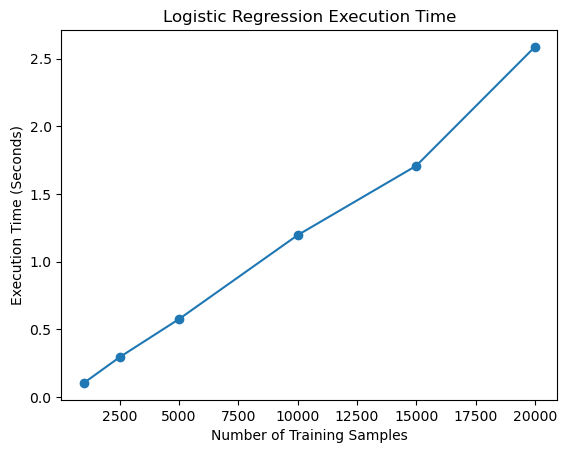

In [145]:
plt.plot(data_sizes,training_times_lr, 'o-') 
plt.xlabel('Number of Training Samples')
plt.ylabel('Execution Time (Seconds)')
plt.title('Logistic Regression Execution Time')
plt.show()

In [223]:
from sklearn.model_selection import ParameterGrid

# Définition de la fonction GridSearch

class GridSearch:
    """ Classe pour l'optimisation de paramètres par GridSearch.
    """
    def __init__(self, datax, datay, params):
        """ Constructeur de la classe GridSearch.
            @param datax: list(str), corpus de textes
            @param datay: list(int), classes correspondantes
            @param model: classifieur par encore entraîné
            @params: dict(str:object), dictionnaire des paramètres à tester et des valeurs qu'elles peuvent prendre
        """
        # Initialisation des scores ainsi que des paramètres correspondant
        self.scores = []
        self.params = []
        
        processing_params = list( ParameterGrid(params['processing']) )
        vectorizer_params = list( ParameterGrid(params['vectorizer']) )
        cv_params = list( ParameterGrid(params['cross_val']) )
        
        print('\n{} combinaisons de paramètres à tester...' . format( len(processing_params) * len(vectorizer_params) * len(cv_params) * 3 ))
        
        # Liste des différents modèles à tester
        classes = [ LinearSVC, MultinomialNB, LogisticRegression ]
        
        # Compteur itérations pour affichage dans le log
        i = 0
        
        for proc_grid in processing_params:
            # Pré-traitement du corpus selon les paramètres choisis
            processed_datax = text_processor(datax, **proc_grid)
            
            for func in classes:
                if func != MultinomialNB:
                    for C in params['cross_val']['C']:
                        # Pour chaque paramètre de régularisation
                        model = func( C = C )
                        #model.set_params(max_iter=5000)    

                        for vec_grid in vectorizer_params:
                            
                            # Représentation sous forme vectorielle
                            vectorizer = vec_grid['type'](ngram_range=vec_grid['ngram_range'])
                            X = vectorizer.fit_transform(processed_datax)

                            # Cross-validation
                            strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)
                            scores_cv = np.mean( cross_val_score(model, X, datay, cv=strat_kfold, scoring=['f1', 'accuracy']) )
                            print('Iter {} : model: {}, vectorizer: {}, params: {}, C: {} --> {}' .format(str(i), str(model), str(vec_grid), str(proc_grid), str(C), str(scores_cv)) )
                            
                            self.scores.append(scores_cv)
                            self.params.append((model, vec_grid, proc_grid, C))
                            i += 1
                else:
                    model = func()
                    #model.set_params(max_iter=5000)    

                    for vec_grid in vectorizer_params:
                            
                        # Représentation sous forme vectorielle
                        vectorizer = vec_grid['type'](ngram_range=vec_grid['ngram_range'])
                        X = vectorizer.fit_transform(processed_datax)
                        model.fit(X, datay)

                        # Cross-validation
                        strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)
                        scores_cv = np.mean( cross_val_score(model, X, datay, cv=strat_kfold, scoring='f1') )
                        print('Iter {} : model: {}, vectorizer: {}, params: {} -> {}' .format(str(i), str(model), str(vec_grid), str(proc_grid), str(scores_cv)) )
                        
                        self.scores.append(scores_cv)
                        self.params.append((str(model), str(vec_grid), str(proc_grid)))
                        i += 1

In [242]:
import pandas as pd
from sklearn.model_selection import ParameterGrid

class BatchGridSearch:
    """ Classe pour l'optimisation de paramètres par GridSearch.
    """
    def __init__(self, datax, datay, params, params_filename='params.txt'):
        """ Constructeur de la classe GridSearch.
            Permet d'écrire dans un fichier param_filename toutes les combinaisons de paramètres à tester.
            @param datax: list(str), corpus de textes
            @param datay: list(int), classes correspondantes
            @params params: dict(str:object), dictionnaire des paramètres à tester et des valeurs qu'elles peuvent prendre
            @params_filename: str, fichier dans lequel on veut écrire la liste de nos paramètres
        """
        self.datax = datax
        self.datay = datay
        self.params = params
        self.params_filename = params_filename
        
        # Grilles de paramètres à tester
        processing_params = list( ParameterGrid(params['processing']) )
        vectorizer_params = list( ParameterGrid(params['vectorizer']) )
        model_params = list( ParameterGrid(params['model']) )
        cv_params = list( ParameterGrid(params['cross_val']) )
        
        # Paramètre du nombre de combinaisons au total
        self.n_combs_ = len(processing_params) * len(model_params) * len(vectorizer_params) * len(cv_params)

        # Ecriture dans un fichier
        with open(params_filename, 'w') as file:
            for processing in processing_params:
                for model in model_params:
                    for vectorizer in vectorizer_params:
                        for cv in cv_params:
                            params = {'processing' : processing, 'vectorizer': vectorizer, 'model': model, 'cross_val': cv}
                            file.write(str(params) + '\n')
        
    
    def compute_batch(self, from_, to_):
        """ Permet d'appliquer la cross-validation sur un batch de la grille de paramètres. La fonction crée un fichier de nom
            'out_{from_}_to_{to_}.txt' dans lequel chaque ligne contient l'indice de la ligne correspondante et le score du
            modèle testé en cross-validation. Les paramètres utilisés sont ceux allant de la ligne from_ à la ligne to_ dans le fichier nommé 
            self.params_filename.
            @params from_: int, indice de la ligne de départ du batch de paramètres à tester dans params_filename
            @param to_: int, indice de la ligne de fin de batch (comprise)
        """        
        # Récupération des paramètres du batch à tester
        with open(self.params_filename, 'r') as file:
            params_grid = file.readlines()
            for i in range(len(params_grid)):
                params_grid[i] = re.sub("<class 'sklearn.feature_extraction.text.([A-Za-z]*)'>", r'\1', params_grid[i])
                params_grid[i] = re.sub("<class 'sklearn.svm.classes.([A-Za-z]*)'>", r'\1', params_grid[i])
                params_grid[i] = re.sub("<class 'sklearn.svm._classes.([A-Za-z]*)'>", r'\1', params_grid[i])
                params_grid[i] = re.sub("<class 'sklearn.naive_bayes.([A-Za-z]*)'>", r'\1', params_grid[i])
                params_grid[i] = re.sub("<class 'sklearn.linear_model.logistic.([A-Za-z]*)'>", r'\1', params_grid[i])
                params_grid[i] = re.sub("<class 'sklearn.linear_model._logistic.([A-Za-z]*)'>", r'\1', params_grid[i])
                
                params_grid[i] = eval( params_grid[i].strip('\n') )
                #params_grid[i]['vectorizer']['type'] = eval( params_grid[i]['vectorizer']['type'] )
    
        print('\n{} combinaisons de paramètres à tester...' . format( to_ - from_ + 1 ))
        
        # Nom du fichier de sortie
        out_filename = 'out_' + str(from_) + '_to_' + str(to_) + '.txt'
        
        # Initialisation du dictionnaire pour la conversion en DataFrame
        df = dict()
        
        with open(out_filename, 'w') as out_file:

            for i in range(from_, to_+1):                
                params = params_grid[i]
                
                # Pré-traitement du corpus selon les paramètres choisis
                processed_datax = text_processor(self.datax, **params['processing'])
                
                # Initialisation du modèle
                func = params['model']['m']
                if func != MultinomialNB:
                    model = func( C = params['cross_val']['C'] )
                else:
                    model = func()
                    
                #model.set_params(max_iter=5000)
                # Représentation sous forme vectorielle
                vectorizer = params['vectorizer']['type'](ngram_range=params['vectorizer']['ngram_range'])
                X = vectorizer.fit_transform(processed_datax)

                # Cross-validation
                strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)
                scores = cross_validate(model, X, self.datay, cv=strat_kfold, scoring = ['accuracy','f1','roc_auc'])
                accuracy = np.mean( scores['test_accuracy'] )
                f1 = np.mean( scores['test_f1'] )
                roc_auc = np.mean( scores['test_roc_auc'] )
                        
                # Ecriture du score dans le fichier de sortie
                out_file.write('{} {} {} {}\n'.format(i, accuracy, f1, roc_auc))
                
                # Ecriture dans un dictionnaire pour l'affichage DataFrame
                line = params
                line['model']['m'] = line['model']['m'].__name__
                line['vectorizer']['type'] = line['vectorizer']['type'].__name__
                
                df[i] = [ i for k, v in line.items() for i in v.values() ]
                df[i].append(accuracy)
        
        # Affichage de sortie
        print('\n*** Fin de traitement, voir le fichier {} ***'.format(out_filename))
        
        # Affichage DataFrame Pandas
        return pd.DataFrame.from_dict(df, orient='index', columns=['language', 'select line', 'lowercase', 'no number', 'no punctuation', 'no stopwords', 'normalize', 'stemming', 'ngram', 'vectorizer', 'model', 'regularization factor', 'score'])

In [243]:
# Lecture des scores (accuracy, f1) pour chaque combinaison de paramètres par BatchGridSearch

def load_scores_df(params_file, scores_files, scores_names):
    """ Lit les fichiers params_files des paramètres et la liste de fichiers dans scores_files, et renvoie les
        scores associés à chaque combinaison sous la forme d'un DataFrame pandas.
        @param params_file: str, nom du fichier contenant toutes les combinaisons de paramètres testées
        @param scores_files: list(str), liste des fichiers contenant les scores obtenus par combinaison
        @param scores_names: list(str), liste des noms des scores
    """
    with open(params_file,'r') as file:
    
        lines = file.readlines()
        data = [['Language','Line','Lower','Remove digit','Remove punctuation','Remove stopwords','Normalize','Stemming','N-gram range','Vectorizer','Model','C','Accuracy score','F1 score', 'ROC-AUC score']]
        
        # Mappings des vectorizers et modèles
        vmap = { CountVectorizer : 'Counter', TfidfVectorizer : 'Tf-Idf' }
        mmap = { LinearSVC : 'Linear SVC', LogisticRegression : 'Logistic Regression', MultinomialNB : 'Naive Bayes' }
        
        for i in range(len(lines)):
            line = lines[i].strip('\n')
            line = re.sub("<class 'sklearn.feature_extraction.text.([A-Za-z]*)'>", r'\1', line)
            line = re.sub("<class 'sklearn.svm.classes.([A-Za-z]*)'>", r'\1', line)
            line = re.sub("<class 'sklearn.svm._classes.([A-Za-z]*)'>", r'\1', line)
            line = re.sub("<class 'sklearn.naive_bayes.([A-Za-z]*)'>", r'\1', line)
            line = re.sub("<class 'sklearn.linear_model.logistic.([A-Za-z]*)'>", r'\1', line)
            line = re.sub("<class 'sklearn.linear_model._logistic.([A-Za-z]*)'>", r'\1', line)
            params = eval(line)

            processing = params['processing']
            vectorizer = params['vectorizer']
            model = params['model']
            cross_val = params['cross_val']
            data.append([processing['language'], processing['line'], processing['lowercase'], processing['no_num'], processing['no_punc'], processing['no_stopwords'], processing['norm'], processing['stemming'], vectorizer['ngram_range'], vmap[vectorizer['type']], mmap[model['m']], cross_val['C']])
    
    for score_file in scores_files:
        with open(score_file,'r') as file:
            lines = file.readlines()
            
            for line in lines:
                i, accuracy, f1, roc_auc = line.split()
                data[int(i)+1] += [float(accuracy), float(f1), float(roc_auc)]
    
    return pd.DataFrame(data[1:], columns=data[0])

In [244]:
# paramètres présidents: 3168 combinaisons
params = {"processing": { "language": ['english'],
                          "line": [None],
                          "no_punc": [True],
                          "no_num": [True],
                          "lowercase": [False,True],
                          "norm": [False,True],
                          "no_stopwords": [False, True],
                          "stemming": [False, True] },
          "vectorizer": {"type": [ CountVectorizer, TfidfVectorizer ], "ngram_range": [(1,1),(1,2),(2,2)]},
          "model": {"m": [ LinearSVC, MultinomialNB, LogisticRegression ] },
          "cross_val": { "C": [ 1 if i == 0 else i * 10 for i in range(5) ] }
         }

In [245]:
bgs = BatchGridSearch(X_train, Y_train, params, 'test.txt')
print('{} combinaisaisons de paramètres à tester' . format(bgs.n_combs_))

1440 combinaisaisons de paramètres à tester


In [241]:
import time

t1 = time.time()
df = bgs.compute_batch(0,1439)
print('Temps d\'exécution: {} s'.format(time.time()-t1))


6 combinaisons de paramètres à tester...
{'processing': {'language': 'english', 'line': None, 'lowercase': True, 'no_num': True, 'no_punc': True, 'no_stopwords': True, 'norm': True, 'stemming': True}, 'vectorizer': {'ngram_range': (2, 2), 'type': <class 'sklearn.feature_extraction.text.TfidfVectorizer'>}, 'model': {'m': <class 'sklearn.linear_model._logistic.LogisticRegression'>}, 'cross_val': {'C': 40}}
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/allaa/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/wh/bdgxw5rj48x6p041447q9z5m0000gn/T/ipykernel_7263/1238839344.py", line 4, in <module>
    df = bgs.compute_batch(0,5)
  File "/var/folders/wh/bdgxw5rj48x6p041447q9z5m0000gn/T/ipykernel_7263/3321347793.py", line 89, in compute_batch
    X = vectorizer.fit_transform(processed_datax)
  File "/Users/allaa/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py", line 1387, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
  File "/Users/allaa/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py", line -1, in _count_vocab
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/allaa/miniconda3/lib/pyt

## 2) Variantes sur les stratégies d'entraînement

- **Sur-apprentissage**. Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

 <br>
- **Equilibrage des données**. Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.


## 3) Estimer les performances de généralisation d'une méthodes
**Ce sera l'enjeu principal du projet : vous disposez d'un ensemble de données, et vous évaluerez les performances sur un ensemble de test auquel vous n'avez pas accès. Il faut donc être capable d'estimer les performances de généralisation du modèles à partir des données d'entraînement.**


Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?